In [1]:
using AeroAcoustics
using HDF5
using PyPlot # only for plotting

In [2]:
csm_file = "DTU_PLCT_NACA63018_trip_5PS_5SS_U0_50_AoA_0_octave-12_CsmEss.h5"

"DTU_PLCT_NACA63018_trip_5PS_5SS_U0_50_AoA_0_octave-12_CsmEss.h5"

In [28]:
# Collect CSM-data and microphone geometry
function DTU_AIAAreadCSM(destfile::String)
    h5open(destfile, "r") do file
        CsmData = read(file, "CsmData")
        fc = CsmData["binCenterFrequenciesHz"]
        CSM = CsmData["csmReal"]+im*CsmData["csmImaginary"]
        CSM = permutedims(CSM,reverse(1:ndims(CSM)))
        MetaData = read(file, "MetaData")
        micgeom = MetaData["ArrayAttributes"]["microphonePositionsM"]
        return FreqArray(CSM,fc),micgeom
    end
    
end
CSM,micgeom = DTU_AIAAreadCSM(csm_file);

In [29]:
# Collect meta data
ArrayAttributes = h5readattr(csm_file,"MetaData/ArrayAttributes")
CsmData = h5readattr(csm_file,"CsmData")
MeasurementData = h5readattr(csm_file,"MeasurementData")
TestAttributes = h5readattr(csm_file,"MetaData/TestAttributes")

Dict{String, Any} with 5 entries:
  "domainBoundsM"       => @NamedTuple{1::Float64, 2::Float64, 3::Float64}[(var…
  "flowType"            => "kevlar"
  "machNumber"          => [0.150235, 0.0, 0.0]
  "coordinateReference" => "array center"
  "testDescription"     => "Airfoil in kevlar-walled wind tunnel"

Task 3

In [30]:
# Setup environment
E = Environment(
    CSM=CSM,
    micgeom=micgeom,
    z0 = TestAttributes["domainBoundsM"][1][3],
    dr = true,
    Nx = 41,
    Ny = 41,
    xlim = (-2,2),
    ylim = (-1,1),
    flim = (400,4000)
);
steeringvectors!(E)

In [31]:
b = beamforming(E);
b3 = narrow2oct(b,3);

In [32]:
# need to store this in /data
SPL.(b)

1681×40 Matrix{Float64}:
 31.7938  NaN       NaN       NaN       …    7.45792  NaN        16.6077
 33.5171   23.745    22.9357  NaN           18.6431   NaN        19.8171
 34.8341   28.7318   29.8718  NaN          NaN        NaN       NaN
 35.9083   31.2155   32.5923   13.8175     NaN        NaN       NaN
 36.8291   32.9449   34.2985   29.3284      16.5513    17.4052  NaN
 37.6618   34.3252   35.5002   32.6432  …   18.2601    18.0598   23.2426
 38.465    35.5417   36.3967   34.6793      20.3368   NaN        21.1036
 39.2959   36.7137   37.1197   36.1473      23.6876   NaN       NaN
 40.2046   37.9263   37.8025   37.2975      20.4566   NaN       NaN
 41.2234   39.2288   38.5962   38.2849      27.395     25.3939  NaN
 42.3551   40.6276   39.6348   39.2471  …   27.4169    25.6662   21.7162
 43.5728   42.091    40.9635   40.3103      16.8096   NaN       NaN
 44.8298   43.566    42.5106   41.5525     NaN        NaN       NaN
  ⋮                                     ⋱                       
 

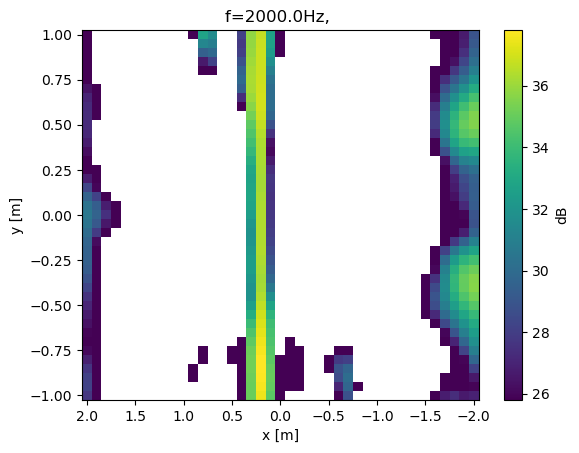

PyObject Text(24.0, 0.5, 'y [m]')

In [39]:
idx = 7
cmax = SPL(maximum(filter(!isnan,b3[:,idx])))
cmin = cmax-12
pcolormesh(E.rx,E.ry,reshape(SPL.(b3[:,idx]),E.Nx,E.Ny)',vmin=cmin, vmax=cmax)
cbar=colorbar()
cbar.set_label("dB")
xlim(reverse(xlim()))
title("f=$(b3.fc[idx])Hz, ")
xlabel("x [m]")
ylabel("y [m]")